<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (DC), Ed Podojil (NYC), (Two to six boring slides by Cody)_

### Lesson Guide
- [Introduce the bikeshare data](#introduce-the-bikeshare-data)
	- [Reading in the data](#reading-in-the-data)
	- [Visualizing the data](#visualizing-the-data)
- [Linear regression basics](#linear-regression-basics)
	- [Form of linear regression](#form-of-linear-regression)
	- [Building a linear regression model](#building-a-linear-regression-model)
	- [Using the model for prediction](#using-the-model-for-prediction)
	- [Does the scale of the features matter?](#does-the-scale-of-the-features-matter)
- [Working with multiple features](#working-with-multiple-features)
	- [Visualizing the data (part 2)](#visualizing-the-data-part-)
	- [Adding more features to the model](#adding-more-features-to-the-model)
- [What is Multicollinearity?](#what-is-multicollinearity)
- [Choosing between models](#choosing-between-models)
	- [Feature selection](#feature-selection)
	- [Evaluation metrics for regression problems](#evaluation-metrics-for-regression-problems)
	- [Comparing models with train/test split and RMSE](#comparing-models-with-traintest-split-and-rmse)
	- [Comparing testing RMSE with null RMSE](#comparing-testing-rmse-with-null-rmse)
- [Creating features](#creating-features)
	- [Handling categorical features](#handling-categorical-features)
	- [Feature engineering](#feature-engineering)
- [Regularization](#regularization)
	- [How does regularization work?](#how-does-regularization-work)
	- [Lasso and ridge path diagrams](#lasso-and-ridge-path-diagrams)
	- [Advice for applying regularization](#advice-for-applying-regularization)
	- [Ridge regression](#ridge-regression)
- [Comparing linear regression with other models](#comparing-linear-regression-with-other-models)


In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="introduce-the-bikeshare-data"></a>
## Introduce the bikeshare data

<a id="reading-in-the-data"></a>
<a id="reading-in-the-data"></a>

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [144]:
# read the data and set the datetime as the index

url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [73]:
# Examine the head
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [74]:
# Examine the shape of the dataframe
bikes.shape

(10886, 11)

Take a minute to look over the data before we answer the following questions.

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?
- How many observations are there?

In [75]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

<a id="visualizing-the-data"></a>
<a id="visualizing-the-data"></a>
### Visualizing the data

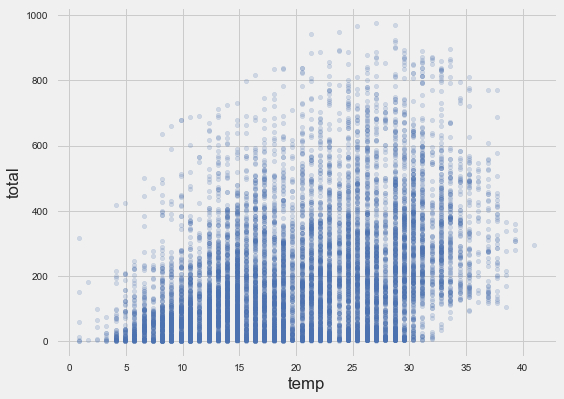

In [76]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2)

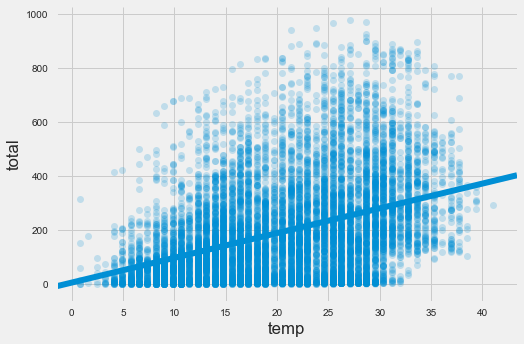

In [77]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

<a id="building-a-linear-regression-model"></a>
<a id="building-a-linear-regression-model"></a>
### Building a linear regression model

In [78]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total

#### Partner-up: Use the sklearn documentation to create a simple linear regression between temperature and total bike rentals

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [79]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
# print the coefficients
intercept = linreg.intercept_
slope = linreg.coef_

Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

<a id="using-the-model-for-prediction"></a>
<a id="using-the-model-for-prediction"></a>
### Using the model for prediction

#### Partner-up: How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [81]:
# manually calculate the prediction
y_25 = (slope * 25) + intercept
print y_25

[ 235.309725]


In [82]:
# use the predict method
linreg.predict(25)

array([ 235.309725])

<a id="does-the-scale-of-the-features-matter"></a>
<a id="does-the-scale-of-the-features-matter"></a>
### Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [83]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


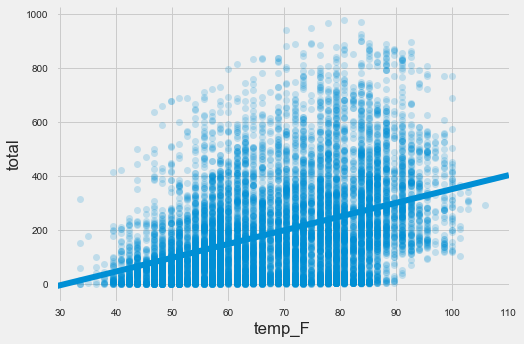

In [84]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

In [85]:
# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

-156.985617821
[ 5.09474471]


In [86]:
# convert 25 degrees Celsius to Fahrenheit
25 * 1.8 + 32

77.0

In [87]:
# predict rentals for 77 degrees Fahrenheit
linreg.predict(77)

array([ 235.309725])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [88]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

<a id="working-with-multiple-features"></a>
## Working with multiple features

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of each other, but all of them should help explain the y variable.

We'll work with bike-share data to showcase what this means and to explain a concept called multicollinearity.

<a id="visualizing-the-data-part-"></a>
<a id="visualizing-the-data-part-"></a>
### Visualizing the data (part 2)

In [89]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

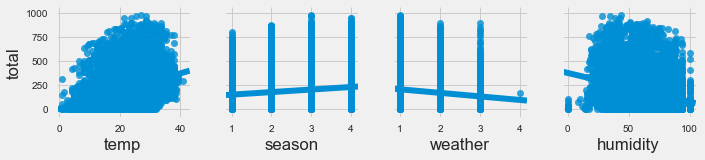

In [90]:
# multiple scatter plots in Seaborn
plt.figure(figsize=(12,10))
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')
plt.show()

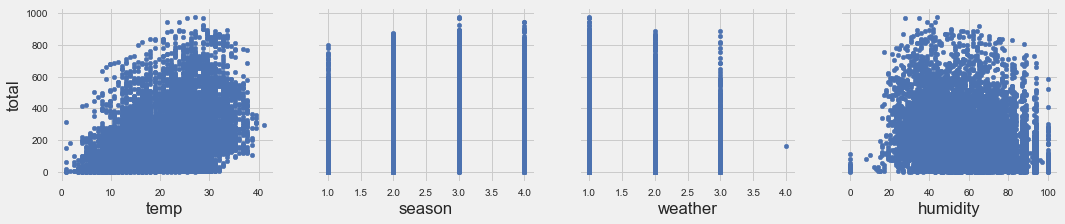

In [35]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are bike rentals actually increasing as the season increases?

In [91]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


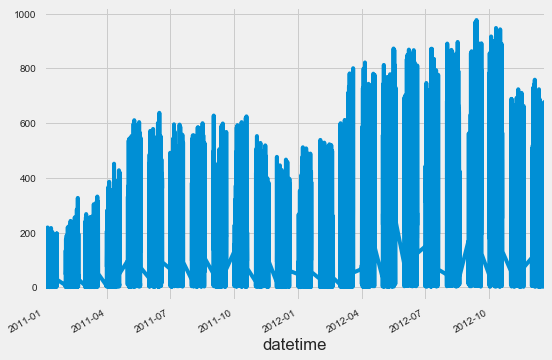

In [92]:
# line plot of rentals
bikes.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [93]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


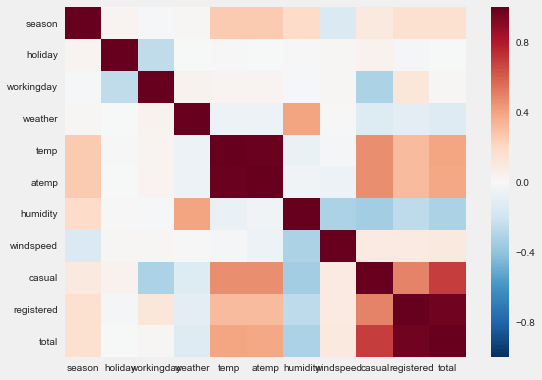

In [94]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr())

What relationships do you notice?

#### Partner-up: Let's run a multiple linear regression with the following variables: temperature, season, weather, and humidity

In [95]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [96]:
# create your X and y datasets
X = bikes[feature_cols]
y = bikes.total
# instantiate and fit your X and y datasets
linreg = LinearRegression()
linreg.fit(X, y)
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

159.520687861
[  7.86482499  22.53875753   6.67030204  -3.11887338]


In [97]:
# pair the feature names with the coefficients using a command called 'zip'
print(pd.Series(list(zip(feature_cols, linreg.coef_))))

0        (temp, 7.86482499248)
1      (season, 22.5387575325)
2     (weather, 6.67030203592)
3    (humidity, -3.1188733824)
dtype: object


Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase/decrease of ___ bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase/decrease of ___ bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase/decrease of ___ bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental increase/decrease of ___ bikes**.

Does anything look incorrect? 

<a id="what-is-multicollinearity"></a>
<a id="what-is-multicollinearity"></a>
## What is Multicollinearity?

With the bike share data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
Axes(0.08,0.07;0.696x0.81)


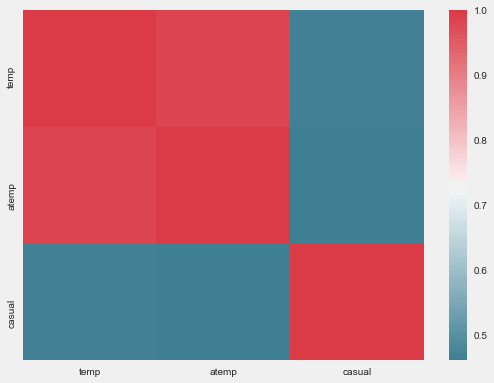

In [98]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'casual']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

In [99]:
# create a list of features
feature_cols = ['temp', 'atemp']

In [100]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

4.2481326458
[ 8.19865874  0.90720808]


In [101]:
# now just use temp
X = bikes[['atemp']]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

-5.51142136857
[ 8.33163614]


The coefficient for temperature feel went from 0.9 to 8.3! That's what multicollinearity can do. It may not necessarily impact our predictions, but it will make our interpretation of our coefficients inconsistent.

<a id="choosing-between-models"></a>
## Choosing between models

<a id="feature-selection"></a>
<a id="feature-selection"></a>
### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- R-squared **always increases** so adding features to your model that are unrelated to the response will always **increase the R-squared value**
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [102]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [103]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

('MAE:', 2.0)
('MSE:', 7.5)
('RMSE:', 2.7386127875258306)


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [104]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

('MAE:', 2.0)
('MSE:', 16.0)
('RMSE:', 4.0)


<a id="comparing-models-with-traintest-split-and-rmse"></a>
<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing models with train/test split and RMSE

In [105]:
from sklearn.model_selection import train_test_split

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [106]:
# compare different sets of features
print(train_test_rmse(['temp', 'season', 'weather', 'humidity']))
print(train_test_rmse(['temp', 'season', 'weather']))
print(train_test_rmse(['weather', 'humidity','temp']))

155.649459131
164.165399763
157.250295181


In [107]:
# using these as features is not allowed!
print(train_test_rmse(['casual', 'registered']))

2.76616750363e-13


<a id="comparing-testing-rmse-with-null-rmse"></a>
<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

In [108]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([ 192.26451139,  192.26451139,  192.26451139, ...,  192.26451139,
        192.26451139,  192.26451139])

In [109]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

## Plotting Residuals
The degree to which we're wrong is important, but _how_ we are wrong is also important to understand

In [110]:
# define a function that accepts a list of features and returns an array of the y_test variables, and the predictions from x_test
def train_test_residuals(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return y_test, y_test - y_pred

actual, residuals = train_test_residuals(['temp', 'season', 'weather', 'humidity'])

### There are two main ways we can check our residuals
   1. Check their distribution
   2. Check their pattern against the ground truth

(array([  62.,  383.,  899.,  706.,  317.,  181.,   77.,   48.,   38.,   11.]),
 array([-335.04924559, -234.92795608, -134.80666657,  -34.68537705,
          65.43591246,  165.55720198,  265.67849149,  365.799781  ,
         465.92107052,  566.04236003,  666.16364954]),
 <a list of 10 Patch objects>)

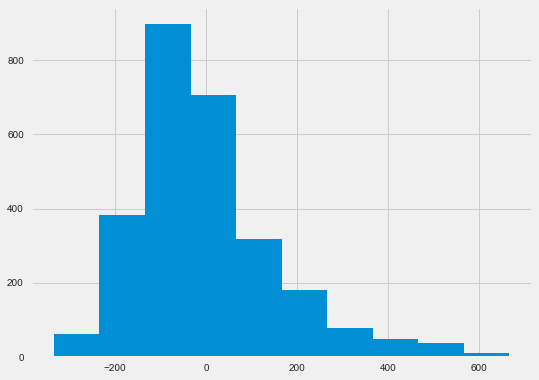

In [57]:
# Plot the distribution of our residuals
plt.hist(residuals)

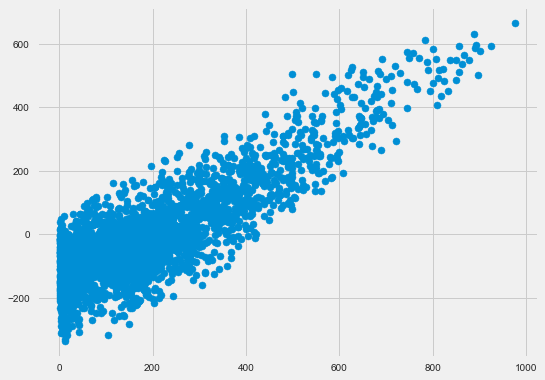

In [111]:
# Use a scatter plot to compare our residuals to their actual value
plt.scatter(actual, residuals)

<a id="creating-features"></a>
## Creating features

<a id="handling-categorical-features"></a>
<a id="handling-categorical-features"></a>
### Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [112]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# print 5 random rows
season_dummies.sample(n=5)

,season_1,season_2,season_3,season_4
datetime,,,,
2012-05-01 09:00:00,0,1,0,0
2012-09-04 23:00:00,0,0,1,0
2011-05-18 21:00:00,0,1,0,0
2012-01-16 20:00:00,1,0,0,0
2011-09-06 09:00:00,0,0,1,0


However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**

In [113]:
# drop the first column
season_dummies.drop('season_1', axis=1, inplace=True)

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [114]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0,0,1


In [115]:
# include dummy variables for season in the model
feature_cols = ['temp','season_2','season_3','season_4','humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
print(pd.Series(list(zip(feature_cols, linreg.coef_))))

0         (temp, 11.1864058636)
1    (season_2, -3.39054309972)
2    (season_3, -41.7368607132)
3     (season_4, 64.4159614682)
4    (humidity, -2.81948163626)
dtype: object


How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

This is much more granular than what we had before (+1 in season => +22.5 increase in bikes)

#### Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [118]:
# compare original season variable with dummy variables
print(train_test_rmse(['temp', 'humidity']))
print(train_test_rmse(['season_2', 'season_3', 'season_4', 'humidity']))
print(train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity']))

157.190191195
161.408754583
161.408754583


#### Why are the coefficients for summer and fall negative when bike rentals clearly increase in those seasons?

- Let's see what happens if we exclude temperature

In [117]:
feature_cols = ['season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
print(pd.Series(list(zip(feature_cols, linreg.coef_))))

0     (season_2, 114.700370674)
1     (season_3, 145.205747822)
2     (season_4, 116.884420162)
3    (humidity, -3.46696450897)
dtype: object


<a id="feature-engineering"></a>
<a id="feature-engineering"></a>
### Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

In [119]:
# hour as a numeric feature
bikes['hour'] = bikes.index.hour

In [120]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([bikes, hour_dummies], axis=1)

In [121]:
# daytime as a categorical feature
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

In [122]:
print(train_test_rmse(['hour']))
print(train_test_rmse(bikes.columns[bikes.columns.str.startswith('hour_')]))
print(train_test_rmse(['daytime']))

165.671742641
128.311205028
144.891163602


##### Let's see what we can do about the seasonality effect

In [123]:
bikes['year'] = bikes.index.year
bikes['time_period'] = np.where(bikes.year==2012, bikes.season+4, bikes.season)

feature_cols = ['time_period','temp','humidity','weather']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y) 
print(pd.Series(list(zip(feature_cols, linreg.coef_))))

0    (time_period, 20.2920818441)
1           (temp, 7.65442192227)
2      (humidity, -2.90837245719)
3        (weather, 4.77007892408)
dtype: object


In [124]:
print(train_test_rmse(['time_period','temp','humidity','weather']))

150.021431826


Time/seasonality is a huge factor in data analysis. This dataset is better suited for a time series model as opposed to linear regression. We will go over those types of models later in the course!

<a id="regularization"></a>
## Regularization

- Regularization is a method for "constraining" or "regularizing" the **size of the coefficients**, thus "shrinking" them towards zero.
- It reduces model variance and thus **minimizes overfitting**.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is **more likely to generalize**.

Our goal is to locate the **optimum model complexity**, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
<a id="how-does-regularization-work"></a>
### How does regularization work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which **minimizes the residual sum of squares (RSS):**

For a regularized linear regression model, we **minimize the sum of RSS and a "penalty term"** that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the **number of features**
- $\beta_j$ is a **model coefficient**
- $\alpha$ is a **tuning parameter:**
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="advice-for-applying-regularization"></a>
<a id="advice-for-applying-regularization"></a>
### Advice for applying regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between Lasso regression and Ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicolinearity in your model.
- If model performance is your primary concern, it is best to try both.

<a id="ridge-regression"></a>
<a id="ridge-regression"></a>
### Ridge regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [131]:
# include dummy variables for season in the model
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [133]:
# alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.674293499


In [134]:
print(pd.Series(list(zip(feature_cols, ridgereg.coef_))))

0         (temp, 8.53753090259)
1        (atemp, 2.45485409876)
2    (season_2, -9.32542956779)
3    (season_3, -40.6789961975)
4     (season_4, 61.1174892836)
5    (humidity, -2.86504483054)
dtype: object


To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization beforehand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [129]:
# try alpha=0.1
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.960986626


In [130]:
# examine the coefficients
print(pd.Series(list(zip(feature_cols, ridgereg.coef_))))

0          (temp, 5.25745265987)
1         (atemp, 4.25452329154)
2    (season_2, -0.179345562752)
3     (season_3, -21.4839426054)
4      (season_4, 56.6822078419)
5     (humidity, -2.65883779146)
dtype: object


<a id="comparing-linear-regression-with-other-models"></a>
<a id="comparing-linear-regression-with-other-models"></a>
## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias

## Your Turn
- Partner up and use the famous 'Boston' Dataset to perform a linear regression.
- Use the sklearn documentation if you need clarification: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [147]:
from sklearn import datasets

from sklearn.datasets import load_boston
boston = load_boston()

print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [136]:
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data['price'] = boston.target
X_train, X_test, y_train, y_test = train_test_split(data.drop('price',axis=1), data.price, random_state=17)

In [148]:
# Do you need to change/encode any of the variables?

# Would a train-test split be appropriate for this

AttributeError: index

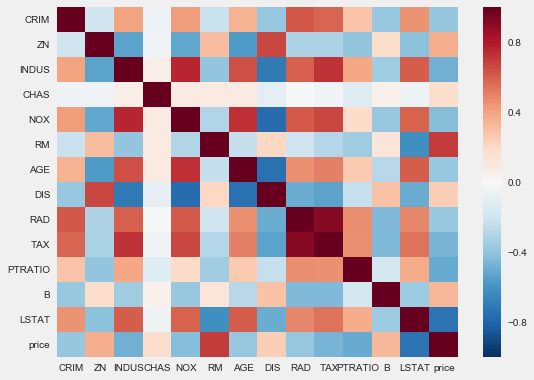

In [150]:
# Plot the relationships between the variables in your dataset

# Do a correlation matrix. Is there any multicollineariy present?
sns.heatmap(data.corr())

In [151]:
# Fit your model
feature_cols = ['NOX', 'AGE']
X = data[feature_cols]
y = data.price
linreg = LinearRegression()
linreg.fit(X, y)


0      (NOX, -25.8769806329)
1    (AGE, -0.0452426889289)
dtype: object


In [152]:
# Print out the feature names, and their coefficients.

print(pd.Series(list(zip(feature_cols, linreg.coef_))))

0      (NOX, -25.8769806329)
1    (AGE, -0.0452426889289)
dtype: object


In [155]:
# What is the R^2 score for your linear regression?
data[['NOX', 'AGE', 'price']].head()

y_true = [24.0, 21.6, 34.7, 33.4, 36.2]
y_pred = [linreg.predict([0.538, 65.2]), linreg.predict([0.469, 78.9]), linreg.predict([0.469, 61.1]), linreg.predict([0.458, 45.8]), linreg.predict([0.458, 54.2])]

from sklearn.metrics import r2_score
r2_score(y_true, y_pred)


/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contain

-0.48176063689939608

In [ ]:
# Is there any feature engineering we can/should do given the data we have? 


In [ ]:
# Does a Ridge Regression improve our score?
